In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
# from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [2]:
## thêm biến đường dẫn 
## sửa lại tên dataframe
data_path = r"D:\Users\CARD\Data\summary_ft&nonft.pkl"
df = pd.read_pickle(data_path)

In [ ]:
df.drop(columns ='CARD_ID',inplace=True)

In [18]:
df = df.fillna(0).replace([np.inf, -np.inf], 0) 

In [ ]:
# df.select_dtypes('object').columns

In [19]:
X = df.loc[:,df.columns != "IS_FRAUD"]
y =  df["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=df["IS_FRAUD"], test_size=0.25)

In [4]:
# def precision_recall(tn, fp, fn, tp):
#     precision = tp/(tp+fp)
#     recall = tp/(tp+fn)
#     f1 = 2*(precision*recall)/(precision+recall)
#     return precision, recall, f1

# def f1(Y_val, predictions):
#     tn, fp, fn, tp = metrics.confusion_matrix(Y_val, predictions).ravel()
#     precision, recall, f1 = precision_recall(tn, fp, fn, tp)
#     f1 = 2*(precision*recall)/(precision+recall)
#     return f1

def evaluation(model, X_val, Y_val, threshold):
    predictions = (model.predict_proba(X_val)[:,1] >=threshold).astype(int)
    precision = precision(predictions, Y_val)
    recall = recall(predictions, Y_val)
    f1 = f1_score(predictions, Y_val)
    return precision, recall, f1

def cross_validation(model, _X, _y, _cv = 5):
    _scoring = ["precision","recall","f1"]
    results = cross_validate(estimator = model,
                             X =_X,
                             y = _y,
                             cv =_cv,
                             scoring = _scoring,
                             return_train_score = True)
    return {"Training Precision": results["train_precision"],
            "Mean Training Precision": results["train_precision"].mean(),
            "Training Recall": results["train_precision"],
            "Mean Training Recall": results["train_recall"].mean(),
            "Training F1 score": results["train_precision"],
            "Mean Training F1 score": results["train_f1"].mean(),
            "Validation Precision": results["test_precision"],
            "Mean Validation Precision": results["test_precision"].mean(),
            "Validation Recall": results["test_recall"],
            "Mean Validation Recall": results["test_recall"].mean(),
            "Validation F1 score": results["test_f1"],
            "Mean Validation F1 score": results["test_f1"].mean()}

def plot(thresholds, scores, precisions, recalls):
    plt.plot(thresholds, scores, '-o', color = 'blue', label='f1 score', linewidth = 2)
    plt.plot(thresholds, precisions, '-o', color = 'green', label='precisions', linewidth = 2)
    plt.plot(thresholds, recalls, '-o', color = 'black', label='recalls', linewidth = 2)
    plt.xlabel('threshold', size = 2)
    plt.legend()
#     plt.savefig("threshold")
    plt.show()

def threshold(model, X_val, Y_val):
    scores = []
    thresholds = []
    precisions = []
    recalls = []
    best_score = 0
    best_threshold = 0

    for threshold in np.arange(0.0, 1.05, 0.01):
        predictions = (model.predict_proba(X_val)[:,1] >=threshold).astype(int)
        m = f1_score(Y_val, predictions, average = 'macro')
        scores.append(m)

        tn, fp, fn, tp = metrics.confusion_matrix(Y_val, predictions).ravel()
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    plot(thresholds, scores, precisions, recalls)
    return thresholds,scores, precisions, recalls, best_threshold

# FIT MODEL

In [20]:
base_model = xgb.XGBClassifier()
base_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
####### Model Calibration
# prob = model.predict_proba(X_val)[:,1]
# bin_edges = np.linspace(0,1, num = 10)
# ## Bin and counts
# histogram,_ = np.histogram(prob, bins = bin_edges)
# bin_counts_0,_ = np.histogram(prob[Y_val==0], bins=bin_edges)
# bin_counts_1,_ = np.histogram(prob[Y_val==1], bins=bin_edges)
# ## print the frequency each bins
# for i in range(len(bin_edges)-1):
#     print(f"Bin {i}:{bin_counts_0[i]} label 0 samples,{bin_counts_1[i]} label 1 samples")

In [ ]:
# import matplotlib.ticker as ticker
# # Add labels and a legend 
# fig, ax = plt.subplots(figsize = (18,12))
# #Create a bar chart of the frequency of label 0 and label 1 samples in each bin
# total_counts = [sum(x) for x in  zip(bin_counts_0, bin_counts_1)] 
# bin_percentages_0 = [count / total_counts[i] * 100 for i, count in enumerate(bin_counts_0)]
# bin_percentages_1 = [count / total_counts[i] * 100 for i, count in enumerate(bin_counts_1)]
# ax.bar(range(len(bin_edges) - 1), bin_percentages_0, color='blue', alpha=0.5, label='Label 0') 
# ax.bar(range(len(bin_edges) - 1), bin_percentages_1, color='green', alpha=0.5, label='Label 1', bottom=bin_percentages_0)
# # Add labels and a legend ax.set_xlabel('Bin')
# ax.set_ylabel('Frequency (%)') 
# ax.set_xticks(range(len(bin_edges) - 1))
# ax.set_xticklabels([f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'for i in range(len(bin_edges) - 1)])
# ax.legend() 
# # Format y-axis as percentages 
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y/100)))
# # Show the plot 
# plt.show() 

In [ ]:
# non_fraud = bin_counts_0.tolist()
# fraud = bin_counts_1.tolist()
# dat = pd.DataFrame({'non_fraud': non_fraud, 'fraud': fraud})
# dat

In [ ]:

thresholds,scores, precisions, recalls, best_threshold = threshold(base_model, X_val, Y_val)
threshold_cover_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_cover_df.to_clipboard()

In [ ]:
list = [i * 0.01 for i in range(0,102)]
result  = []
for x in list:
    predictions = (base_model.predict_proba(X_val)[:,1] >= x).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(Y_val, predictions).ravel()
    result.append({'Threshold': x,'TN':tn,'FP': fp, 'FN': fn ,'TP':tp})
result= pd.DataFrame(result, columns = ['Threshold','TN','FP','FN','TP'])

# CALCULATE AUPRC 165 VARS 

In [6]:
df_val = pd.concat([X_val,Y_val],1)

In [7]:
df_val.shape

(9889, 167)

In [8]:
df_val_fraud = df_val[df_val['IS_FRAUD']==1]

In [ ]:
df_val_fraud.shape

In [9]:
len(df_val_fraud)/len(df_val)

0.004550510668419456

## RESAMPLING 

In [10]:
from imblearn.over_sampling import SMOTE
## function to find the best n in range
def find_n_for_smote(df,n_sample):

    """
    Find the best value of n in 'for i in range(n)' to balance classes using SMOTE.
    Parameters:
    - df: DataFrame containing the dataset
    - n_sample: number of non-fraudulent samples to use for generating synthetic samples
    Returns:
    - n: the best value of n such that the ratio of fraudulent transactions to total transactions is 0.005
    """
    target_ratio = 0.005
    tolerance = 0.0005
    n = 0

    while True:
        n += 1
        list_generate_nonfraud = [df[df['IS_FRAUD']==0]]
        for i in range(n):
            df_check = generate_nonfraud(df=df,n_sample=n_sample)
            list_generate_nonfraud.append(df_check)
        df_val_nonfraud = pd.concat(list_generate_nonfraud)
        total_samples = len(df_val_fraud)+ len(df_val_nonfraud)
        fraud_ratio = len(df_val_fraud)/ total_samples
        if abs(fraud_ratio / target_ratio - 1) <tolerance:
            break
    return n

## Function to generate non-fraud instances
def generate_nonfraud(df=df_val, n_sample = 10):
    df_val_non_fraud_sample = df[df['IS_FRAUD']==0].sample(n_sample)
    df_val_sample = pd.concat([df_val_fraud,df_val_non_fraud_sample])

    # Define the SMOTE over-sampling strategy
    oversample = SMOTE(sampling_strategy=1, random_state=42)

    # Fit and apply the SMOTE strategy to generate new samples
    X_oversampled, y_oversampled = oversample.fit_resample(df_val_sample.loc[:, df_val_sample.columns!='IS_FRAUD'], df_val_sample["IS_FRAUD"])
    df_gen = pd.concat([X_oversampled, y_oversampled], 1)
    return df_gen[df_gen['IS_FRAUD']==0].reset_index(drop=True)

In [21]:
## check the ratio of fraud among total 
fraud_cases = len(df_val[df_val['IS_FRAUD']==1])
non_fraud_cases = len(df_val[df_val['IS_FRAUD']==0])
ratio = fraud_cases/(fraud_cases + non_fraud_cases)

## Upsampling
if ratio >0.005:
    n = find_n_for_smote(df=df_val, n_sample = 10)
    list_generate_nonfraud = [df_val[df_val['IS_FRAUD']==0]]
    for i in range(n):
        df_check = generate_nonfraud(df=df_val, n_sample = 10)
        list_generate_nonfraud.append(df_check)
    df_val_nonfraud = pd.concat(list_generate_nonfraud)
    df_val_nonfraud = df_val_nonfraud.drop_duplicates()
    df_val_nonfraud.reset_index(drop=True)
    data_test = pd.concat([df_val_fraud,df_val_nonfraud])
    # print(data_test)
else:
    ##
    rus = RandomUnderSampler(sampling_strategy=0.005, random_state=42)
    data_under_sampled, label_undersampled = rus.fit_resample(X_val,Y_val)
    df_adj = data_under_sampled
    df_adj['IS_FRAUD'] = label_undersampled
    data_test = df_adj

In [22]:
X_adj = data_test.drop('IS_FRAUD',1)
Y_adj = data_test[['IS_FRAUD']]
from sklearn.metrics import precision_recall_curve, auc
y_prob = base_model.predict_proba(X_adj)[:,1]
precision,recall, _ = precision_recall_curve(Y_adj,y_prob)
auprc = auc(recall,precision)

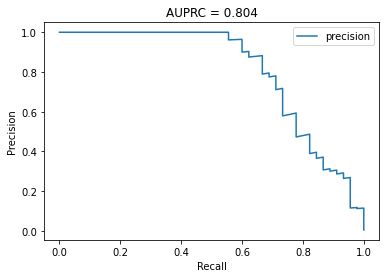

In [23]:
### plot AUPRC
df = pd.DataFrame({'recall':recall,'precision':precision})
ax = df.plot(x = 'recall', y = 'precision', title =f'AUPRC = {auprc:.3f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

# FEATURE IMPORTANCE 779 VARS

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
feature_importances = base_model.feature_importances_

In [ ]:
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

fig = plt.figure(figsize=(20,44)) 

plt.barh(range(len(feature_importances)), feature_importances[sorted_idx])
plt.yticks(range(len(feature_importances)),sorted_features)
plt.xlabel('feature Importances')
plt.ylabel('Feature')
plt.show()

In [ ]:
importances_df  = pd.DataFrame({'feature':feature_names,'importance':feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False)
importances_df

Gain method

In [ ]:
importance_gain = base_model.get_booster().get_score(importance_type = 'gain')

In [ ]:
importance_gain_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance': list(importance_gain.values())
})
importance_gain_df = importance_gain_df.sort_values(by = 'Importance', ascending= False)

In [ ]:
importance_gain_df.to_clipboard()

In [ ]:
importance_total_gain = base_model.get_booster().get_score(importance_type = 'total_gain')
importance_total_gain = pd.DataFrame({
    'Feature': list(importance_total_gain.keys()),
    'Importance': list(importance_total_gain.values())
})
importance_total_gain = importance_total_gain.sort_values(by = 'Importance', ascending= False)
importance_total_gain

In [ ]:
importance_total_gain.to_clipboard()

In [ ]:
importance_weight = base_model.get_booster().get_score(importance_type = 'weight')
importance_weight = pd.DataFrame({
    'Feature': list(importance_weight.keys()),
    'Importance': list(importance_weight.values())
})
importance_weight = importance_weight.sort_values(by = 'Importance', ascending= False)
importance_weight

In [ ]:
importance_weight.to_clipboard()

In [ ]:
importance_cover = base_model.get_booster().get_score(importance_type = 'cover')
importance_cover = pd.DataFrame({
    'Feature': list(importance_cover.keys()),
    'Importance': list(importance_cover.values())
})
importance_cover = importance_cover.sort_values(by = 'Importance', ascending= False)
importance_cover

# Intersection Model

In [ ]:
importance_gain = base_model.get_booster().get_score(importance_type = 'cover')
importance_weight = base_model.get_booster().get_score(importance_type = 'cover')
importance_total_gain = base_model.get_booster().get_score(importance_type = 'cover')
importance_cover = base_model.get_booster().get_score(importance_type = 'cover')
set_gain = set(importance_gain.keys())
set_weight = set(importance_weight.keys())
set_total_gain = set(importance_total_gain.keys())
set_cover = set(importance_cover.keys())

In [ ]:
intersections = set_gain.intersection(set_weight,set_gain,set_total_gain,set_cover)
intersections

In [ ]:
mylist = list(intersections)

In [ ]:
mylist.insert(0,'IS_FRAUD')

In [ ]:
intersection = pd.DataFrame(df, columns= mylist)

In [ ]:
X = intersection.loc[:,intersection.columns != "IS_FRAUD"]
y =  intersection["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=intersection["IS_FRAUD"], test_size=0.25)

In [ ]:
intersection_model = xgb.XGBClassifier()
intersection_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(intersection_model, X_val, Y_val)
threshold_intersection_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_intersection_df

In [ ]:
threshold_intersection_df

In [ ]:
threshold_intersection_df.to_clipboard()

# Model Gain

In [ ]:
importance_gain = base_model.get_booster().get_score(importance_type = 'gain')
importance_gain = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance': list(importance_gain.values())
})
importance_gain = importance_gain.sort_values(by = 'Importance', ascending= False)
importance_gain

In [ ]:
importance_gain_top100 = importance_gain.head(100)
list_gain = importance_gain_top100.Feature.tolist()
list_gain.insert(0,'IS_FRAUD')

In [ ]:
gain_df = pd.DataFrame(df, columns= list_gain)

In [ ]:
X = gain_df.loc[:,gain_df.columns != "IS_FRAUD"]
y =  gain_df["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=gain_df["IS_FRAUD"], test_size=0.25)
gain_model = xgb.XGBClassifier()
gain_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(gain_model, X_val, Y_val)
threshold_gain_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_gain_df

## Tuning hyperparameter

In [ ]:
paramaters = {
    "nthread":[4],
    "objective": ["binary:logistic"],
    "learning_rate":[0.1, 0.01],
    "max_depth":range(3,6,2),
    "min_child_weight":range(1,6,2),
    "subsample":[i/10 for i in range(6,10)],
    "colsample_bytree":[i/10 for i in range(6,10)],
    "n_estimators":[10, 15],
    "gamma":[i/10 for i in range(0,5)],
    "seed":[1337],
    "min_split_loss":[0.1],
    "min_child_weight":range(1,6,2)}

gain_model_opt = XGBClassifier()
# use_label_encoder=False,objective='binary:logistic',eval_metric="aucpr"
gain_model_opt = GridSearchCV(estimator=gain_model_opt,
                    param_grid =paramaters,
                    cv=10,
                    scoring = "f1")

gain_model_opt.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(gain_model_opt, X_val, Y_val)
threshold_gain_opt = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_gain_opt

In [ ]:
threshold_gain_opt.to_clipboard()

# Model Total Gain

In [ ]:
importance_total_gain = base_model.get_booster().get_score(importance_type = 'total_gain')
importance_total_gain = pd.DataFrame({
    'Feature': list(importance_total_gain.keys()),
    'Importance': list(importance_total_gain.values())
})
importance_total_gain = importance_total_gain.sort_values(by = 'Importance', ascending= False)
## extract top 100 highest importance score
importance_total_gain_top100 = importance_total_gain.head(100)
list_total_gain = importance_total_gain_top100.Feature.tolist()
list_total_gain.insert(0,'IS_FRAUD')
## split data and train model
total_gain_df = pd.DataFrame(df, columns= list_gain)
X = total_gain_df.loc[:,total_gain_df.columns != "IS_FRAUD"]
y =  total_gain_df["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=total_gain_df["IS_FRAUD"], test_size=0.25)
total_gain_model = xgb.XGBClassifier()
total_gain_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(total_gain_model, X_val, Y_val)
threshold_total_gain_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_total_gain_df

In [ ]:
threshold_total_gain_df.to_clipboard()

# Model Weight

In [ ]:
importance_weight = base_model.get_booster().get_score(importance_type = 'weight')
importance_weight = pd.DataFrame({
    'Feature': list(importance_weight.keys()),
    'Importance': list(importance_weight.values())
})
importance_weight = importance_weight.sort_values(by = 'Importance', ascending= False)
## extract top 100 highest importance score
importance_weight_top100 = importance_weight.head(100)
list_weight = importance_weight_top100.Feature.tolist()
list_weight.insert(0,'IS_FRAUD')
## split data and train model
weight_df = pd.DataFrame(df, columns= list_weight)
X = weight_df.loc[:,weight_df.columns != "IS_FRAUD"]
y =  weight_df["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=weight_df["IS_FRAUD"], test_size=0.25)
weight_model = xgb.XGBClassifier()
weight_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(weight_model, X_val, Y_val)
threshold_weight_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_weight_df

In [ ]:
threshold_weight_df.to_clipboard()

# Model Cover

In [ ]:
importance_cover = base_model.get_booster().get_score(importance_type = 'cover')
importance_cover = pd.DataFrame({
    'Feature': list(importance_cover.keys()),
    'Importance': list(importance_cover.values())
})
importance_cover = importance_cover.sort_values(by = 'Importance', ascending= False)
## extract top 100 highest importance score
importance_cover_top100 = importance_cover.head(100)
list_cover = importance_cover_top100.Feature.tolist()
list_cover.insert(0,'IS_FRAUD')
## split data and train model
cover_df = pd.DataFrame(df, columns= list_cover)
X = cover_df.loc[:,cover_df.columns != "IS_FRAUD"]
y =  cover_df["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=cover_df["IS_FRAUD"], test_size=0.25)
cover_model = xgb.XGBClassifier()
cover_model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(cover_model, X_val, Y_val)
threshold_cover_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_cover_df.to_clipboard()

In [ ]:
# bestgrid_model = model.best_estimator_
# bestgrid_model_result = cross_validation(bestgrid_model, X, y, 10)
# print("Precision:" ,bestgrid_model_result["Mean Validation Precision"])
# print("Recall:" ,bestgrid_model_result["Mean Validation Recall"])
# print("f1 score:" ,bestgrid_model_result["Mean Validation F1 score"])

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(base_model, X_val, Y_val)
threshold_df = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 score", "precision", "recalls"])
threshold_df

In [ ]:
list = [i * 0.05 for i in range(0,20)]
result  = []
for x in list:
    predictions = (base_model.predict_proba(X_val)[:,1] >= x).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(Y_val, predictions).ravel()
    result.append({'Threshold': x,'TN':tn,'FP': fp, 'FN': fn ,'TP':tp})
result_df = pd.DataFrame(result, columns = ['Threshold','TN','FP','FN','TP'])

In [ ]:
result_df.rename(columns={'Threshold':'threshold'}, inplace=True)
model_alert_result = pd.merge(threshold_df, result_df, on = 'threshold')

In [ ]:
model_alert_result

## NGƯỠNG CẢNH BÁO MODEL

In [ ]:
model_alert_result['Số lượng cảnh báo bộ dữ liệu lấy mẫu'] = model_alert_result['TP']+model_alert_result['FP']

In [ ]:
model_alert_result

In [ ]:
model_alert_result['Tỷ lệ thẻ lấy mẫu / toàn hàng'] = 0.5
model_alert_result['Số lượng cảnh báo toàn hàng ước tính'] = model_alert_result['Số lượng cảnh báo bộ dữ liệu lấy mẫu']/0.5

In [ ]:
model_alert_result

In [ ]:
model_alert_result.to_csv(r'C:\Users\admin\Documents\MB\Card\Credit Card Model Result\model_metrics_201var.csv')

## ALTER 20 VARIABLES WITH HIGHEST IMPORTANCE

In [ ]:
df_20_vars = importances_df_201var.head(20)

In [ ]:
df_20_vars

In [ ]:
df_20_vars = df_201var[['REDUCING_AMOUNT_TRANS_CNT_24H',
 'MERCHANT_TRANS_AMOUNT_1H',
 'TRANS_CNT_24H',
 'AGE_GREATER_3M_IND',
 'SOURCE_CONTRACT',
 'CURRENT_AGE',
 'FAIL_PERC_6H',
 'CARD_AGE',
 'FAIL_CNT_24H',
 'TRANS_SPD',
 'FAIL_PERC_24H',
 'EXCD_FREQ_LIMIT_IND',
 'EXCD_AMNT_LIMIT_PERC_30T',
 'MERCHANT_TRANS_AMOUNT_24H',
 'MERCHANT_TRANS_AMOUNT_3H',
 'HIGH_VALUE_IND_3H',
 'TRANS_AMOUNT_OVER_MAX_30D',
 'TRANS_AMOUNT_A_DAY_IND',
 'REDUCING_AMOUNT_TRANS_PERC_3H',
 'TRANS_SPD_MEAN_5','IS_FRAUD']]

In [ ]:
df_20_vars.to_csv(r'C:\Users\admin\Documents\MB\Card\Credit Card Model Result\df_20_vars.csv')

In [ ]:
from sklearn.model_selection import train_test_split
X = df_20_vars.loc[:,df_20_vars.columns != "IS_FRAUD"]
y =  df_20_vars["IS_FRAUD"]
X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=df_20_vars["IS_FRAUD"], random_state=1412)

In [ ]:
X_val

In [ ]:
paramaters = {
    "nthread":[4],
    "objective": ["binary:logistic"],
    "learning_rate":[0.1, 0.01],
    "max_depth":range(3,6,2),
    "min_child_weight":range(1,6,2),
    "subsample":[i/10 for i in range(6,10)],
    "colsample_bytree":[i/10 for i in range(6,10)],
    "n_estimators":[10, 15],
    "gamma":[i/10 for i in range(0,5)],
    "seed":[1337],
    "min_split_loss":[0.1],
    "min_child_weight":range(1,6,2)}

base_model_20_vars = XGBClassifier(use_label_encoder=False,objective='binary:logistic',eval_metric="aucpr")
model = GridSearchCV(estimator=base_model_20_vars,
                    param_grid =paramaters,
                    cv=10,
                    scoring = "f1")

model.fit(X_train,Y_train, eval_set=[(X_val,Y_val)], verbose = 0)

### 20-VAR MODEL IMPORTANCE

In [ ]:
best_dt = model.best_estimator_

In [ ]:
importances = best_dt.feature_importances_

In [ ]:
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

fig = plt.figure(figsize=(20,44)) 

plt.barh(range(len(importances)), feature_importances[sorted_idx])
plt.yticks(range(len(importances)),sorted_features)
plt.xlabel('feature Importances')
plt.ylabel('Feature')
plt.show()

In [ ]:
importances_df_20var  = pd.DataFrame({'feature':feature_names,'importance':importances})
importances_df_20var = importances_df_20var.sort_values('importance', ascending=False)
importances_df_20var

In [ ]:
importances_df_20var.to_csv(r'C:\Users\admin\Documents\MB\Card\Credit Card Model Result\importance_model_20var.csv')

### Model 20 var Metrics

In [ ]:
thresholds,scores, precisions, recalls, best_threshold = threshold(model, X_val, Y_val)
threshold_df_20_var = pd.DataFrame(zip(thresholds,scores, precisions, recalls),
                           columns = ["threshold","F1 scores", "precision", "recalls"])
threshold_df_20_var

In [ ]:
list = [i * 0.05 for i in range(0,21)]
result  = []
for x in list:
    predictions = (model.predict_proba(X_val)[:,1] >= x).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(Y_val, predictions).ravel()
    result.append({'Threshold': x,'TN':tn,'FP': fp, 'FN': fn ,'TP':tp})
result_20var = pd.DataFrame(result, columns = ['Threshold','TN','FP','FN','TP'])

### NGƯỠNG CẢNH BÁO MODEL 20 BIẾN


In [ ]:
result_20var.rename(columns={'Threshold':'threshold'}, inplace=True)
model_alert_result = pd.merge(threshold_df_20_var, result_20var, on = 'threshold')

In [ ]:
model_alert_result

In [ ]:
model_alert_result['Số lượng cảnh báo bộ dữ liệu lấy mẫu'] = model_alert_result['TP']+model_alert_result['FP']

In [ ]:
model_alert_result['Tỷ lệ thẻ lấy mẫu / toàn hàng'] = 0.5
model_alert_result['Số lượng cảnh báo toàn hàng ước tính'] = model_alert_result['Số lượng cảnh báo bộ dữ liệu lấy mẫu']/0.5

In [ ]:
model_alert_result.to_excel(r'C:\Users\admin\Documents\MB\Card\Credit Card Model Result\model_alert_result_20var.xlsx')